In [1]:
from library.common import Database
import time

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default
TRAIN = dt.datetime(2010,1,1).date()      


db = Database()


In [2]:
features = ['CO2 Emission']
data_table = 'consolidated_data_csv'
df = pd.read_sql(data_table, db.config)
col = ['Year']
col.extend(features)
df = df[col]


In [3]:
# dataset  = df[df['Country Code'].eq('USA')].copy()
dataset = df.groupby('Year').sum(features).reset_index(drop = False)
dataset['Year'] = dataset['Year'] = pd.to_datetime(dataset['Year'], format='%Y')

In [4]:
dataset

,Year,CO2 Emission
0,1960-01-01,18522281.0
1,1961-01-01,18557475.0
2,1962-01-01,19211160.0
3,1963-01-01,20239974.0
4,1964-01-01,21325218.0
...,...,...
56,2016-01-01,69418020.0
57,2017-01-01,70313803.0
58,2018-01-01,71723860.0
59,2019-01-01,71850177.0


In [5]:
series = TimeSeries.from_dataframe(dataset, time_col = 'Year', value_cols = features)

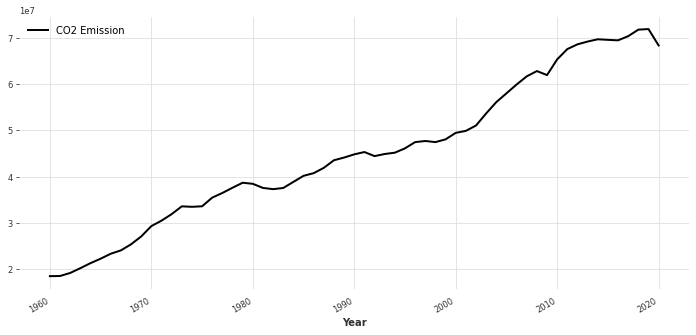

In [6]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [7]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

is_seasonal = False

seasonal? False


SPLIT AT:  2010-01-01 00:00:00


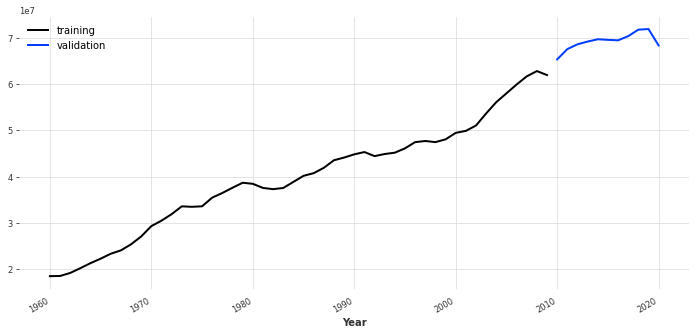

In [8]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
    
print('SPLIT AT: ',split_at)
train, val = series.split_before(split_at)
# n_tests = round(len(dataset)/4)
# train, val = series[:-n_tests], series[-n_tests:]

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [9]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results


In [10]:
# prepare Naive forecaster

m_naive = NaiveDrift()


In [11]:
# prepare Exponential Smoothing forecaster

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
    

In [12]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

In [13]:
# prepare ARIMA forecaster

y = np.asarray(series.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [14]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100


In [15]:
# laundry list of forecasters to run

models = [ 
    # m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet
]


In [16]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: Theta(-3.1515151515151505)
completed: Theta(-3.1515151515151505):0.07806804700000036sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : BIC=1454.627, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : BIC=1449.884, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : BIC=1452.911, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : BIC=1452.968, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=1446.079, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.091 seconds
completed: Auto-ARIMA:0.14330412300000006sec
beginning: Naive drift model
completed: Naive drift model:0.04758955199999981sec
beginning: Prophet
completed: Prophet:4.823317508000001sec


In [17]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,Theta(-3.1515151515151505),Auto-ARIMA,Naive drift model,Prophet
MAPE,2.952,17.926,3.762,4.465
MAE,2018037.138,12494687.727,2588385.601,3104508.597
R squared,1.181,54.992,1.513,4.661
RMSE,2600781.408,13177771.797,2791682.672,4189975.119
RMSLE,0.038,0.211,0.041,0.057
time,0.078,0.143,0.048,4.823


In [18]:
# RUN the forecasters and tabulate their prediction accuracy and processing time - exclude the Naive forecast

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0 and i != 3: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,Theta(-3.1515151515151505),Auto-ARIMA,Naive drift model
MAPE,2.952,17.926,3.762
MAE,2018037.138,12494687.727,2588385.601
R squared,1.181,54.992,1.513
RMSE,2600781.408,13177771.797,2791682.672
RMSLE,0.038,0.211,0.041
time,0.078,0.143,0.048


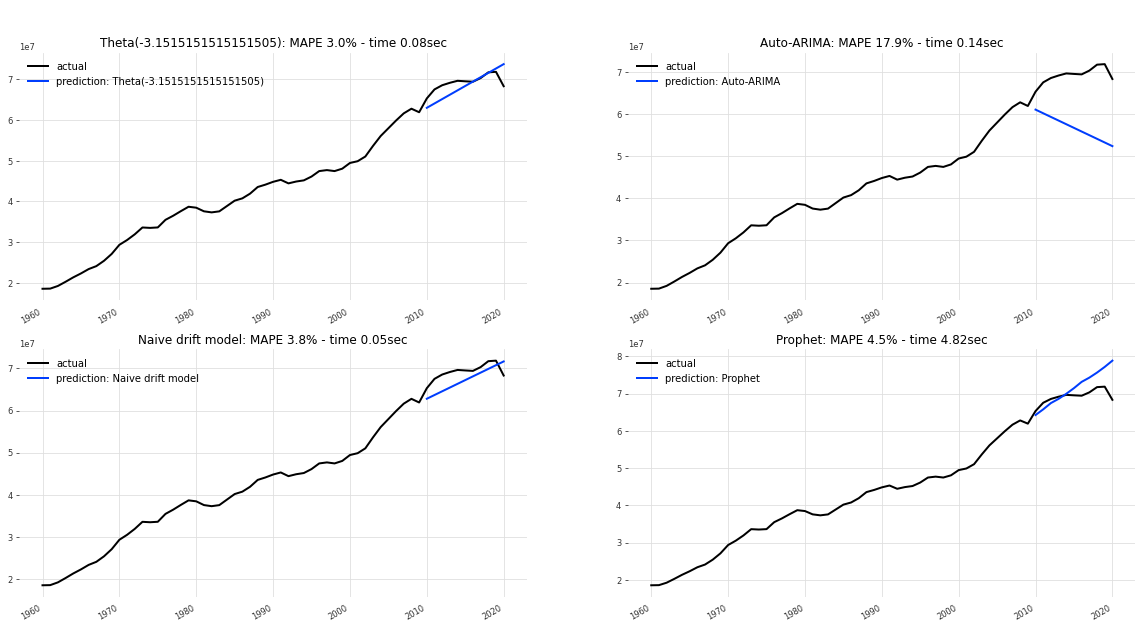

In [19]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()


In [20]:
act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]




Ljung-Box test for white-noise residuals: p-value > alpha?
Theta(-3.1515151515151505) : 0.318457270989474
Auto-ARIMA : 0.059337153197380456
Naive drift model : 0.6428938241422156
Prophet : 0.14227652698551269

test for normality of residuals: p-value > alpha?
Theta(-3.1515151515151505) : 0.020722435014765776
Auto-ARIMA : 0.7758963312599402
Naive drift model : 0.0020008694797538193
Prophet : 0.17641795664284807


[None, None, None, None]

ValueError: max_lag must be greater than or equal to 1 and less than len(ts).

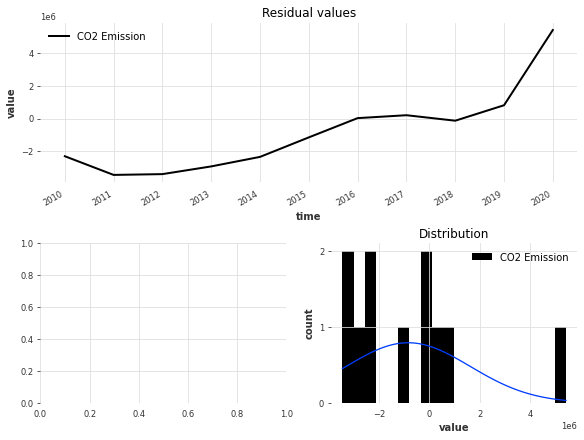

In [21]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act

        df_desc = pd.concat([df_desc, resid.describe()], axis=1)

        plot_residuals_analysis(resid);
        plt.title(str(m))
        

In [ ]:
# descriptive statistics of the forecast series
df_desc.columns = [str(m) for m in models]
print(df_desc)